<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/arize-logo-white.jpg" width="200"/>
        <br>
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://arize.com/docs/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://arize-ai.slack.com/join/shared_invite/zt-2w57bhem8-hq24MB6u7yE_ZF_ilOYSBw#/shared-invite/email">Community</a>
    </p>
</center>
<h1 align="center">Agent Tool Calling Classification Evals</h1>

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted approach to evaluating agent tool calling,
- to provide an experimental framework for users to iterate and improve on an agent tool calling template.

## Install Dependencies and Import Libraries

In [ ]:
!pip install -qq \
    "arize-phoenix-evals>=2.0" \
    anthropic \
    openai \
    matplotlib \
    pandas \
    pyarrow \
    pycm \
    scikit-learn \
    tiktoken \
    seaborn

In [1]:
import json
import os
from getpass import getpass

import matplotlib.pyplot as plt
import openai
import pandas as pd
from pycm import ConfusionMatrix

from phoenix.evals.llm import LLM

pd.set_option("display.max_colwidth", None)

## Download Benchmark Dataset

We'll evaluate the evaluation system consisting of a few example user prompts, with corresponding tool choices and ground truth answers, in addition to an evaluation prompt template against benchmark datasets of user queries and the corresponding tools called with ground-truth labels. We will be using the Berkeley Function-Calling Leaderboard dataset. This dataset is commonly used for agent applications that call tools as a benchmark.

In [2]:
import pandas as pd
import requests

# Load dataset
url = "https://huggingface.co/datasets/gorilla-llm/Berkeley-Function-Calling-Leaderboard/resolve/main/BFCL_v3_exec_multiple.json"
response = requests.get(url)
dataset = [json.loads(line) for line in response.text.strip().splitlines()]

# Collect all unique tool definitions (these are all the tools the agent
# can choose from, as well as their parameters)
unique_tools = {}
for entry in dataset:
    for tool in entry.get("function", []):
        if tool["name"] not in unique_tools:
            unique_tools[tool["name"]] = tool

tool_definitions_text = "\n".join(
    f"{tool['name']}: {tool['description']} | Parameters: {json.dumps(tool['parameters'])}"
    for tool in unique_tools.values()
)


# Prepare data for evaluation
eval_data = []
for entry in dataset:
    question = entry["question"][0][0]["content"]
    ground_truths = entry.get("ground_truth", [])
    for gt in ground_truths:
        eval_data.append(
            {"question": question, "tool_call": gt, "tool_definitions": tool_definitions_text}
        )

df_eval = pd.DataFrame(eval_data)
df_eval.head()

question  \
0                                                                                                                  I'm playing a dice game and want to calculate my chances. I roll the die 20 times, and I'm trying to figure out the probability of landing on a 6 exactly five times, considering each roll has a one in six chance of being a 6. Could you help me with that?   
1      I'm working on a machine learning model, comparing the characteristics of two objects. The feature vectors for these objects are [0.5, 0.7, 0.2, 0.9, 0.1] for the first object and [0.4, 0.6, 0.3, 0.8, 0.2] for the second. To understand how similar these objects are, I need to calculate the cosine similarity between these two vectors. Can you help me with that?   
2                                                                                                                                                                           I'm currently conducting a physics experiment, and I have this object that weighs 50 kilograms and takes up a space of about 10 cubic meters. Could you help me calculate the density of this object?   
3                                                                                                   I'm working on a physics experiment where we're tracking the movement of a special object. It starts off at 15 m/s, and we're accelerating it at a rate of 9.8 m/s². I need to calculate how far it will have traveled after 10 seconds. Can you crunch those numbers for me?   
4  I'm conducting a physics experiment involving charged particles and electric fields. There's a particle that I've introduced into the field, and it carries a charge of exactly 5 coulombs. The electric field itself has a potential difference of 10 volts. I need to calculate the electrostatic potential energy for this scenario. Can you help me with that calculation?   

                                                                                           tool_call  \
0                                                        calc_binomial_probability(n=20, k=5, p=1/6)   
1  calculate_cosine_similarity(vectorA=[0.5, 0.7, 0.2, 0.9, 0.1], vectorB=[0.4, 0.6, 0.3, 0.8, 0.2])   
2                                                              calculate_density(mass=50, volume=10)   
3                           calculate_displacement(initial_velocity=15.0, acceleration=9.8, time=10)   
4                                 calculate_electrostatic_potential_energy(charge=5.0, voltage=10.0)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

## Modify Benchmark Dataset

The BFCL Dataset does not have any `negative` examples, i.e. only `question`, `available_tools`, and `ground_truth` are present. In order to accurately benchmark our LLM-as-a-Judge, this code snippet appends some `incorrect` examples to our dataset, by adding 20 rows of data where the `incorrect` tool is selected with correspondingly incorrect parameters.

In [3]:
import json
import random
import re


# Parse tool definitions into a dict: tool_name -> list of required parameters
def extract_tool_param_templates(tool_definitions):
    tools = {}
    pattern = r"^(\w+):.*?\| Parameters: (.*)$"
    for line in tool_definitions.strip().split("\n"):
        match = re.match(pattern, line.strip())
        if match:
            name, param_json = match.groups()
            try:
                param_schema = json.loads(param_json)
                required = param_schema.get("required", [])
                tools[name] = required
            except json.JSONDecodeError:
                continue
    return tools


tool_param_templates = extract_tool_param_templates(tool_definitions_text)
tool_names = list(tool_param_templates.keys())

# Sample 20 wrong examples
wrong_examples = []
for i in range(20):
    row = df_eval.iloc[i]
    question = row["question"]
    correct_tool_call_str = row["tool_call"]

    # Get correct tool name (assume it's before the first '(')
    try:
        correct_tool_name = correct_tool_call_str.split("(")[0]
    except Exception as e:
        print(f"Skipping row {i} due to error: {e}")
        continue

    # Get a different tool
    incorrect_tools = [tool for tool in tool_names if tool != correct_tool_name]
    if not incorrect_tools:
        continue

    wrong_tool = random.choice(incorrect_tools)
    required_params = tool_param_templates.get(wrong_tool, [])

    # Build dummy argument string
    dummy_args = []
    for param in required_params:
        dummy_value = random.choice(
            [42, 3.14, '"example"', "[1, 2, 3]", "True"]
        )  # random but plausible
        dummy_args.append(f"{param}={dummy_value}")

    wrong_tool_call = f"{wrong_tool}({', '.join(dummy_args)})"

    wrong_examples.append(
        {
            "question": question,
            "tool_call": wrong_tool_call,
            "tool_definitions": tool_definitions_text,
        }
    )

# Create and label the correct examples
df_eval["true_label"] = "correct"

# Create and label the incorrect examples
df_wrong = pd.DataFrame(wrong_examples)
df_wrong["true_label"] = "incorrect"

# Combine both datasets
df_combined = pd.concat([df_eval, df_wrong], ignore_index=True)

# OPTIONAL: Shuffle AFTER labeling
df_eval_final = df_combined.sample(frac=1).reset_index(drop=True)

## Define Agent Tool Calling Prompt Template

Define the default template used to evaluate agent tool calling.
You can tweak this template and evaluate its performance.

In [4]:
TOOL_CALLING_PROMPT_TEMPLATE = """
You are an evaluation assistant evaluating questions and tool calls to
determine whether the tool called would answer the question. The tool
calls have been generated by a separate agent, and chosen from the list of
tools provided below. It is your job to decide whether that agent chose
the right tool to call.

    [BEGIN DATA]
    ************
    [Question]: {question}
    ************
    [Tool Called]: {tool_call}
    [END DATA]

"incorrect" means that the chosen tool would not answer the question,
the tool includes information that is not presented in the question,
or that the tool signature includes parameter values that don't match
the formats specified in the tool signatures below.

"correct" means the correct tool call was chosen, the correct parameters
were extracted from the question, the tool call generated is runnable and correct,
and that no outside information not present in the question was used
in the generated question.

    [Tool Definitions]: {tool_definitions}
"""

Eval template variables:

- **question** : The question the user poses
- **tool_call** : The tool that is actually called (ground truth)
- **tool_definitions** : All the available tools to the agent

## Configure the LLM

Configure your API keys.

In [5]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")

openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key


# Set Anthropic API key
if not (anthropic_api_key := os.getenv("ANTHROPIC_API_KEY")):
    anthropic_api_key = getpass("🔑 Enter your Anthropic API key: ")

os.environ["ANTHROPIC_API_KEY"] = anthropic_api_key

## Evaluate the Dataset Using Phoenix

The follow cell will evaluate a dataset using multiple models and may take a while to run.

In [6]:
from tqdm import tqdm

from phoenix.evals import ClassificationEvaluator, async_evaluate_dataframe

# List of OpenAI model codes to benchmark
open_ai_models = [
    "gpt-5",
    "gpt-4-omni",
    "gpt-4o-mini",
    "gpt-4o",
    # "gpt-4",  # GPT-4 (March 2023)
    # "gpt-4-turbo",  # GPT-4 Turbo (November 2023)
    # "gpt-3.5-turbo",  # GPT-3.5 Turbo (March 2023)
    # "o1",  # OpenAI's first reasoning model
    # "o1-mini",  # Smaller version of o1
    # "o3",  # Successor to o1 with improved reasoning
    # "o3-mini",  # Smaller version of o3
    # "o4-mini",  # Latest mini reasoning model (April 2025)
]


all_results = []

# ---------- Evaluate OpenAI Models ----------
for model_name in tqdm(open_ai_models):
    print(f"\n🧪 Evaluating OpenAI model: {model_name}")

    llm = LLM(provider="openai", model=model_name)
    tool_call_evaluator = ClassificationEvaluator(
        name="tool_call_evaluator",
        llm=llm,
        prompt_template=TOOL_CALLING_PROMPT_TEMPLATE,
        choices={"correct": 1, "incorrect": 0},
    )
    results = await async_evaluate_dataframe(
        dataframe=df_eval,
        evaluators=[tool_call_evaluator],
    )

    all_results.append(results)

# Show the results for the last OpenAI model
results.head()

  0%|          | 0/4 [00:00<?, ?it/s]


🧪 Evaluating OpenAI model: gpt-5


 25%|██▌       | 1/4 [05:53<17:41, 353.87s/it]


🧪 Evaluating OpenAI model: gpt-4-omni


 25%|██▌       | 1/4 [05:55<17:41, 353.87s/it]

Exception in worker on attempt 1: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [05:56<17:41, 353.87s/it]

Exception in worker on attempt 1: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [05:57<17:41, 353.87s/it]

Exception in worker on attempt 2: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [05:57<17:41, 353.87s/it]

Exception in worker on attempt 3: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [05:58<17:41, 353.87s/it]

Exception in worker on attempt 2: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [05:59<17:41, 353.87s/it]

Exception in worker on attempt 1: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [06:00<17:41, 353.87s/it]

Exception in worker on attempt 3: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [06:01<17:41, 353.87s/it]

Exception in worker on attempt 2: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [06:02<17:41, 353.87s/it]

Exception in worker on attempt 3: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [06:03<17:41, 353.87s/it]

Exception in worker on attempt 4: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [06:04<17:41, 353.87s/it]

Exception in worker on attempt 4: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [06:05<17:41, 353.87s/it]

Exception in worker on attempt 4: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [06:06<17:41, 353.87s/it]

Exception in worker on attempt 5: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [06:07<17:41, 353.87s/it]

Exception in worker on attempt 5: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [06:08<17:41, 353.87s/it]

Exception in worker on attempt 6: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [06:08<17:41, 353.87s/it]

Exception in worker on attempt 5: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [06:09<17:41, 353.87s/it]

Exception in worker on attempt 7: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [06:10<17:41, 353.87s/it]

Exception in worker on attempt 8: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [06:11<17:41, 353.87s/it]

Exception in worker on attempt 6: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [06:12<17:41, 353.87s/it]

Exception in worker on attempt 6: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [06:13<17:41, 353.87s/it]

Exception in worker on attempt 9: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [06:13<17:41, 353.87s/it]

Exception in worker on attempt 7: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [06:15<17:41, 353.87s/it]

Exception in worker on attempt 10: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [06:15<17:41, 353.87s/it]

Exception in worker on attempt 8: raised NotFoundError("Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}")
Requeuing...


 25%|██▌       | 1/4 [06:16<17:41, 353.87s/it]

Retries exhausted after 11 attempts: Error code: 404 - {'error': {'message': 'The model `gpt-4-omni` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}


 50%|█████     | 2/4 [06:17<05:19, 159.88s/it]


🧪 Evaluating OpenAI model: gpt-4o-mini


 75%|███████▌  | 3/4 [07:03<01:47, 107.66s/it]


🧪 Evaluating OpenAI model: gpt-4o


100%|██████████| 4/4 [07:47<00:00, 116.88s/it]


question  \
0                                                                                                                  I'm playing a dice game and want to calculate my chances. I roll the die 20 times, and I'm trying to figure out the probability of landing on a 6 exactly five times, considering each roll has a one in six chance of being a 6. Could you help me with that?   
1      I'm working on a machine learning model, comparing the characteristics of two objects. The feature vectors for these objects are [0.5, 0.7, 0.2, 0.9, 0.1] for the first object and [0.4, 0.6, 0.3, 0.8, 0.2] for the second. To understand how similar these objects are, I need to calculate the cosine similarity between these two vectors. Can you help me with that?   
2                                                                                                                                                                           I'm currently conducting a physics experiment, and I have this object that weighs 50 kilograms and takes up a space of about 10 cubic meters. Could you help me calculate the density of this object?   
3                                                                                                   I'm working on a physics experiment where we're tracking the movement of a special object. It starts off at 15 m/s, and we're accelerating it at a rate of 9.8 m/s². I need to calculate how far it will have traveled after 10 seconds. Can you crunch those numbers for me?   
4  I'm conducting a physics experiment involving charged particles and electric fields. There's a particle that I've introduced into the field, and it carries a charge of exactly 5 coulombs. The electric field itself has a potential difference of 10 volts. I need to calculate the electrostatic potential energy for this scenario. Can you help me with that calculation?   

                                                                                           tool_call  \
0                                                        calc_binomial_probability(n=20, k=5, p=1/6)   
1  calculate_cosine_similarity(vectorA=[0.5, 0.7, 0.2, 0.9, 0.1], vectorB=[0.4, 0.6, 0.3, 0.8, 0.2])   
2                                                              calculate_density(mass=50, volume=10)   
3                           calculate_displacement(initial_velocity=15.0, acceleration=9.8, time=10)   
4                                 calculate_electrostatic_potential_energy(charge=5.0, voltage=10.0)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

## Evaluate Anthropic Models

In [7]:
# List of Claude (Anthropic) models to benchmark
anthropic_models = [
    "claude-3-opus-20240229",  # Claude 3 Opus
    "claude-3-sonnet-20240229",  # Claude 3 Sonnet
    "claude-3-haiku-20240307",  # Claude 3 Haiku
    "claude-opus-4-20250514",  # Claude Opus 4
    "claude-sonnet-4-20250514",  # Claude Sonnet 4
]


# ---------- Evaluate Anthropic Models ----------
for model_name in tqdm(anthropic_models):
    print(f"\n🧪 Evaluating Anthropic model: {model_name}")

    llm = LLM(provider="anthropic", model=model_name)
    tool_call_evaluator = ClassificationEvaluator(
        name="tool_call_evaluator",
        llm=llm,
        prompt_template=TOOL_CALLING_PROMPT_TEMPLATE,
        choices={"correct": 1, "incorrect": 0},
    )
    results = await async_evaluate_dataframe(
        dataframe=df_eval,
        evaluators=[tool_call_evaluator],
    )

    all_results.append(results)

# Show the results for the last OpenAI model
results.head()

  0%|          | 0/5 [00:00<?, ?it/s]


🧪 Evaluating Anthropic model: claude-3-opus-20240229


 20%|██        | 1/5 [02:01<08:04, 121.19s/it]


🧪 Evaluating Anthropic model: claude-3-sonnet-20240229


 20%|██        | 1/5 [02:02<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 1: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h54mCQafFJwN72BjCH"}
Requeuing...


 20%|██        | 1/5 [02:03<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 1: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h593R44Yx14Qnghe8D"}
Requeuing...


 20%|██        | 1/5 [02:04<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 1: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h5DJ9vGYZLVRo5Tt16"}
Requeuing...


 20%|██        | 1/5 [02:05<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 2: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h5HbcsdGsM13xnPrwh"}
Requeuing...


 20%|██        | 1/5 [02:06<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 2: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h5MJcJDu9UardJak9q"}
Requeuing...


 20%|██        | 1/5 [02:07<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 2: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h5RU95KhtHJ3xr85ve"}
Requeuing...


 20%|██        | 1/5 [02:08<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 3: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h5VduoKxTSc4vYmva3"}
Requeuing...


 20%|██        | 1/5 [02:09<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 4: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h5ZTbsoXh8Zh7Ux2x6"}
Requeuing...


 20%|██        | 1/5 [02:09<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 5: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h5dau1KoVq47EnQAiM"}
Requeuing...


 20%|██        | 1/5 [02:10<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 3: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h5hDg7qusCrorxL1nq"}
Requeuing...


 20%|██        | 1/5 [02:11<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 3: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h5mAZYMsYVJvX4v1Mj"}
Requeuing...


 20%|██        | 1/5 [02:12<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 4: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h5punEtAQENvZVLZK2"}
Requeuing...


 20%|██        | 1/5 [02:13<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 4: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h5tjEGamsUsEdkTung"}
Requeuing...


 20%|██        | 1/5 [02:14<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 5: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h5xgr6HJzUY9h4mYDA"}
Requeuing...


 20%|██        | 1/5 [02:15<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 6: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h62Bh4k13cxurepv1n"}
Requeuing...


 20%|██        | 1/5 [02:16<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 5: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h65tC5JjDKSPx55zxs"}
Requeuing...


 20%|██        | 1/5 [02:17<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 6: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h69fQUVq8SWtoku72y"}
Requeuing...


 20%|██        | 1/5 [02:17<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 7: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h6DPe3trUTK4T3uHxm"}
Requeuing...


 20%|██        | 1/5 [02:18<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 8: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h6GoGcSo6EqzpZo6XL"}
Requeuing...


 20%|██        | 1/5 [02:19<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 7: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h6LRJxvW1mWKCxUPPr"}
Requeuing...


 20%|██        | 1/5 [02:20<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 6: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h6Pxss8T94NmdhjcsJ"}
Requeuing...


 20%|██        | 1/5 [02:21<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 7: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h6TkasJSYR88LPWBVV"}
Requeuing...


 20%|██        | 1/5 [02:22<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 8: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h6XM8hxdzDebzL8AeP"}
Requeuing...


 20%|██        | 1/5 [02:22<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 9: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h6aSAvdbWjPaiGyCDo"}
Requeuing...


 20%|██        | 1/5 [02:23<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 10: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h6dqZU6mJqQu5hnAHq"}
Requeuing...


 20%|██        | 1/5 [02:24<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 8: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h6hSbuXyR5hPHYBr2p"}
Requeuing...


 20%|██        | 1/5 [02:25<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Exception in worker on attempt 9: raised litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h6khZEfzWZMWtXKJRZ"}
Requeuing...


 20%|██        | 1/5 [02:26<08:04, 121.19s/it]


Provider List: https://docs.litellm.ai/docs/providers


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.

Retries exhausted after 11 attempts: litellm.NotFoundError: AnthropicException - {"type":"error","error":{"type":"not_found_error","message":"model: claude-3-sonnet-20240229"},"request_id":"req_011CU3h6p1jjxkTo7xvo7Xbb"}


 40%|████      | 2/5 [02:27<03:15, 65.22s/it] 


🧪 Evaluating Anthropic model: claude-3-haiku-20240307


 60%|██████    | 3/5 [03:10<01:50, 55.28s/it]


🧪 Evaluating Anthropic model: claude-opus-4-20250514


 80%|████████  | 4/5 [05:22<01:25, 85.48s/it]


🧪 Evaluating Anthropic model: claude-sonnet-4-20250514


100%|██████████| 5/5 [07:03<00:00, 84.74s/it]


question  \
0                                                                                                                  I'm playing a dice game and want to calculate my chances. I roll the die 20 times, and I'm trying to figure out the probability of landing on a 6 exactly five times, considering each roll has a one in six chance of being a 6. Could you help me with that?   
1      I'm working on a machine learning model, comparing the characteristics of two objects. The feature vectors for these objects are [0.5, 0.7, 0.2, 0.9, 0.1] for the first object and [0.4, 0.6, 0.3, 0.8, 0.2] for the second. To understand how similar these objects are, I need to calculate the cosine similarity between these two vectors. Can you help me with that?   
2                                                                                                                                                                           I'm currently conducting a physics experiment, and I have this object that weighs 50 kilograms and takes up a space of about 10 cubic meters. Could you help me calculate the density of this object?   
3                                                                                                   I'm working on a physics experiment where we're tracking the movement of a special object. It starts off at 15 m/s, and we're accelerating it at a rate of 9.8 m/s². I need to calculate how far it will have traveled after 10 seconds. Can you crunch those numbers for me?   
4  I'm conducting a physics experiment involving charged particles and electric fields. There's a particle that I've introduced into the field, and it carries a charge of exactly 5 coulombs. The electric field itself has a potential difference of 10 volts. I need to calculate the electrostatic potential energy for this scenario. Can you help me with that calculation?   

                                                                                           tool_call  \
0                                                        calc_binomial_probability(n=20, k=5, p=1/6)   
1  calculate_cosine_similarity(vectorA=[0.5, 0.7, 0.2, 0.9, 0.1], vectorB=[0.4, 0.6, 0.3, 0.8, 0.2])   
2                                                              calculate_density(mass=50, volume=10)   
3                           calculate_displacement(initial_velocity=15.0, acceleration=9.8, time=10)   
4                                 calculate_electrostatic_potential_energy(charge=5.0, voltage=10.0)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

## Show Results

Let's see how well different models performed as a Judge! We'll show:
- Confusion Matrix for one model (GPT 4o)
- F1 score per model benchmarked, to compare how different models perform as a judge vs the ground truth
-  An agreement matrix to see which models agree with each other as judges.

/var/folders/5r/4zhmkbjs6rg6kbz87n1kctpm0000gp/T/ipykernel_10386/3202364637.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


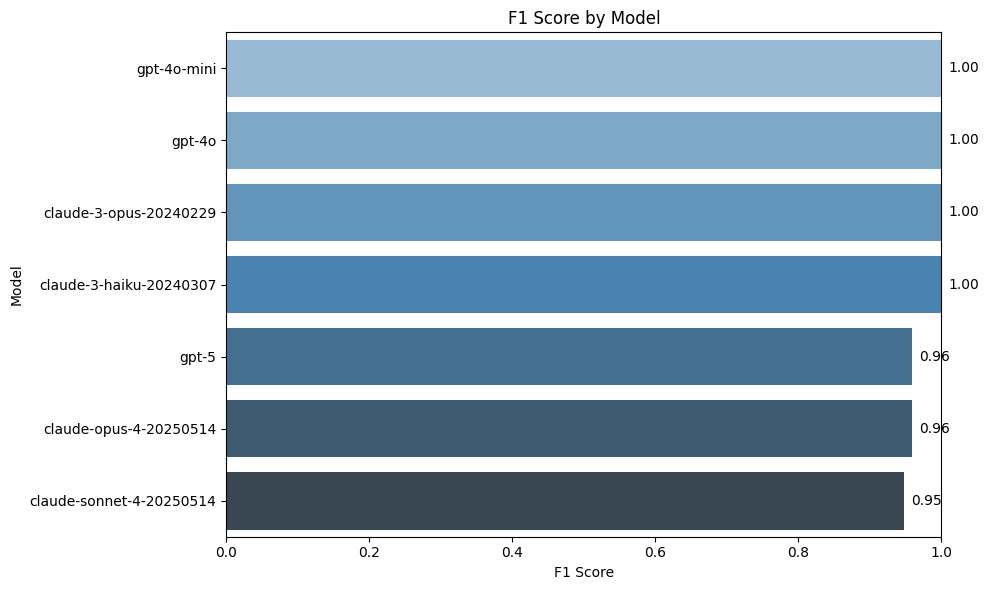

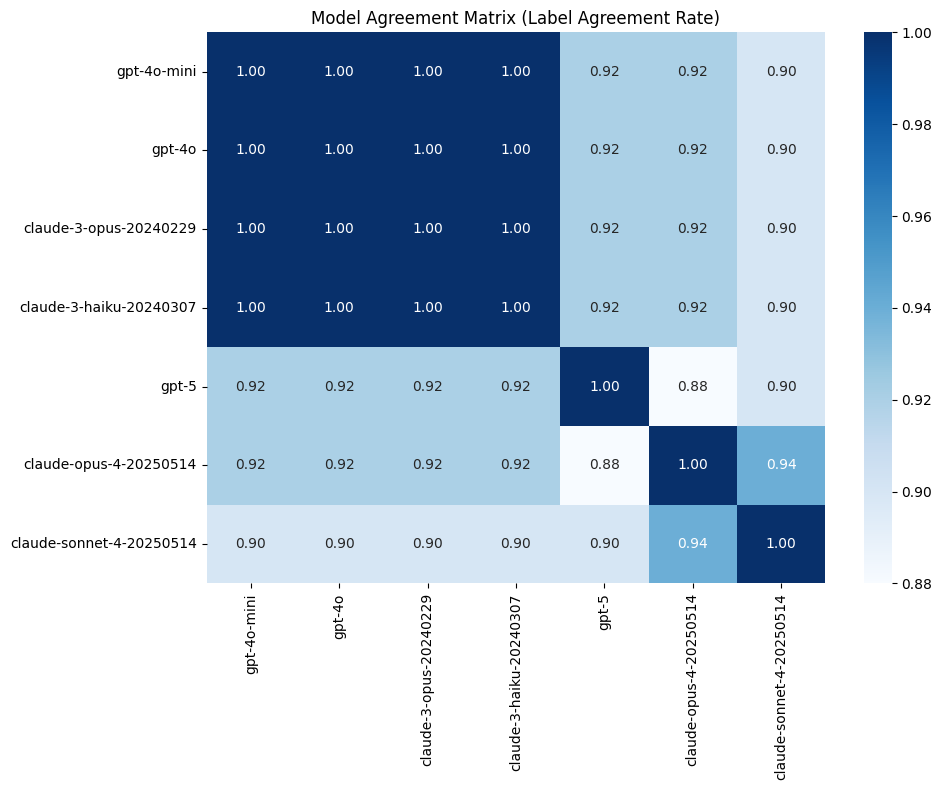

/Users/xandersong/phoenix/.venv/lib/python3.10/site-packages/pycm/utils.py:399: RuntimeWarning: Specified classes are not a subset of the classes in the actual and predicted vectors.
  warn(CLASSES_WARNING, RuntimeWarning)


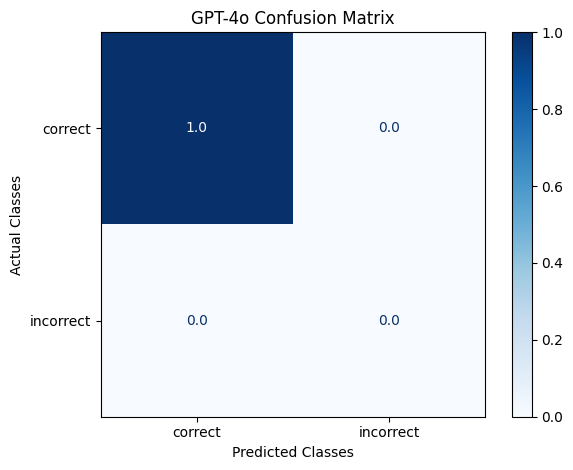

In [8]:
import json

import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Combine results and save
df_all_models = pd.concat(all_results, ignore_index=True)
df_all_models = df_all_models.dropna(subset=["tool_call_evaluator_score"])
df_all_models["label"] = df_all_models["tool_call_evaluator_score"].apply(
    lambda score: json.loads(score)["label"]
)
df_all_models["model"] = df_all_models["tool_call_evaluator_score"].apply(
    lambda score: json.loads(score)["metadata"]["model"]
)
df_all_models.to_csv("judge_results_all_models.csv", index=False)

# Compute metrics
metrics = []
models = df_all_models["model"].unique()

for model_name in models:
    df_model = df_all_models[df_all_models["model"] == model_name]

    # Keep only valid predictions and labels
    df_model = df_model[
        df_model["label"].isin(["correct", "incorrect"])
        & df_model["true_label"].isin(["correct", "incorrect"])
    ]

    # Use real ground truth, given we added some incorrect examples
    true_labels = df_model["true_label"].tolist()
    pred_labels = df_model["label"].tolist()

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, pos_label="correct", zero_division=0)
    recall = recall_score(true_labels, pred_labels, pos_label="correct", zero_division=0)
    f1 = f1_score(true_labels, pred_labels, pos_label="correct", zero_division=0)

    metrics.append(
        {
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
        }
    )

# Create dataframe and sort it
df_metrics = pd.DataFrame(metrics)
df_metrics_sorted = df_metrics.sort_values("F1 Score", ascending=False)

# Preserve order of models for plotting
model_order = df_metrics_sorted["Model"].tolist()

# Plot with fixed order
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_metrics_sorted, x="F1 Score", y="Model", palette="Blues_d", order=model_order
)
plt.title("F1 Score by Model")
plt.xlim(0, 1)

# Add labels at correct y-axis positions
for i, model in enumerate(model_order):
    score = df_metrics_sorted[df_metrics_sorted["Model"] == model]["F1 Score"].values[0]
    ax.text(score + 0.01, i, f"{score:.2f}", va="center")

plt.tight_layout()
plt.show()

# ---- Generate agreement Matrix for models -------

# Generate a consistent ID for each example
df_all_models["example_id"] = df_all_models.groupby("model").cumcount()

# Pivot to wide format: one row per example, one column per model
df_pivot = df_all_models.pivot(index="example_id", columns="model", values="label")

# Compute agreement rates between models
agreement_matrix = pd.DataFrame(index=model_order, columns=model_order)

for m1 in model_order:
    for m2 in model_order:
        agreement = (df_pivot[m1] == df_pivot[m2]).mean()
        agreement_matrix.loc[m1, m2] = agreement

agreement_matrix = agreement_matrix.astype(float)

# ----------------------------------------
# Plot Agreement Heatmap
# ----------------------------------------

plt.figure(figsize=(10, 8))
sns.heatmap(agreement_matrix, annot=True, cmap="Blues", fmt=".2f", cbar=True)
plt.title("Model Agreement Matrix (Label Agreement Rate)")
plt.tight_layout()
plt.show()

# ---------------- Confusion Matrix for GPT-4o ----------------

# Filter to GPT-4o predictions and valid labels
df_4o = df_all_models[
    (df_all_models["model"] == "gpt-4o")
    & (df_all_models["label"].isin(["correct", "incorrect"]))
    & (df_all_models["true_label"].isin(["correct", "incorrect"]))
]

true_labels_4o = df_4o["true_label"].tolist()
pred_labels_4o = df_4o["label"].tolist()
choices = ["correct", "incorrect"]  # class order

# Generate and plot confusion matrix
confusion_matrix_4o = ConfusionMatrix(
    actual_vector=true_labels_4o,
    predict_vector=pred_labels_4o,
    classes=choices,
)
confusion_matrix_4o.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)
plt.title("GPT-4o Confusion Matrix")
plt.tight_layout()
plt.show()